Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
importing Jupyter notebook from DataCleaning.ipynb
['REAL' 'FAKE']
Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


2023-11-19 22:19:59.353904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100000]
	 [[{{node Placeholder/_0}}]]
2023-11-19 22:19:59.354127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-11-19 22:19:59.359450: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.


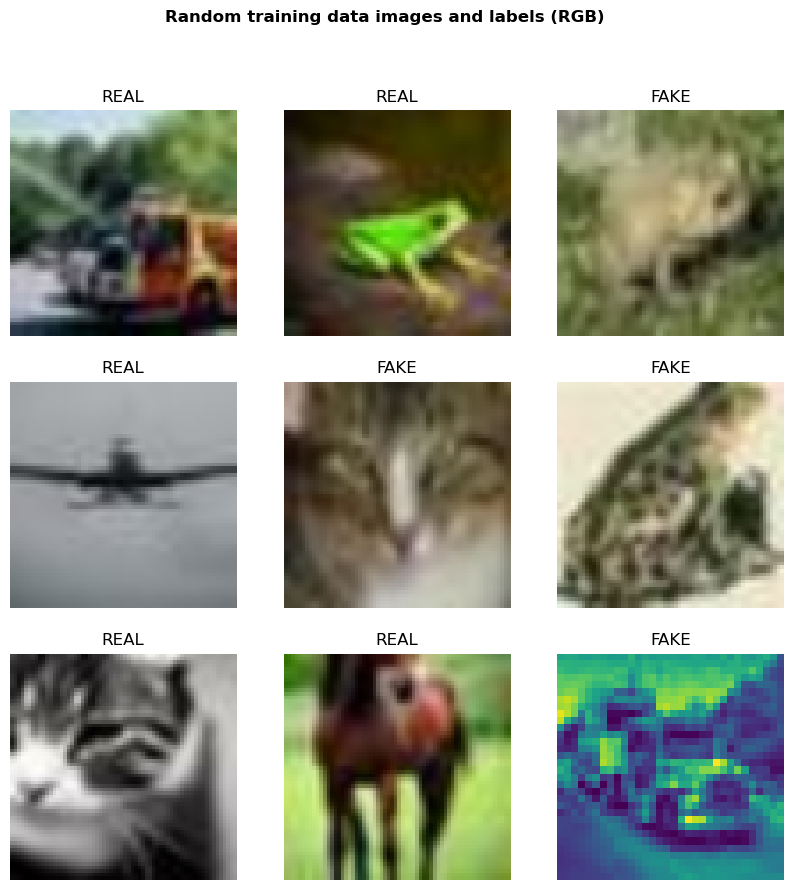

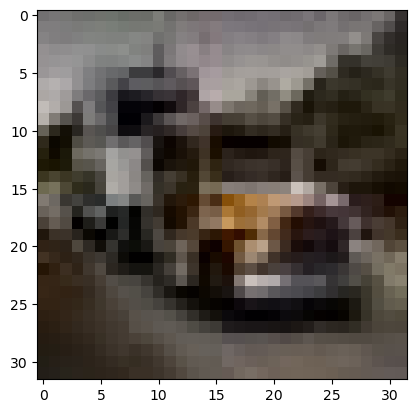

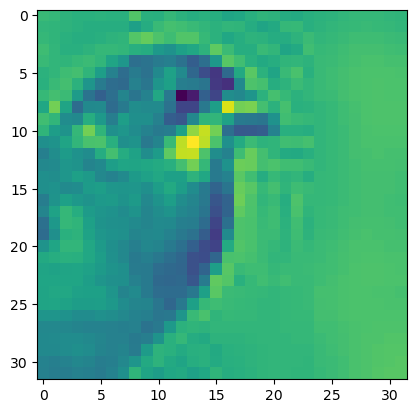

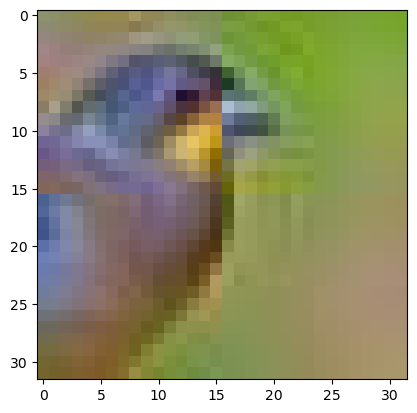

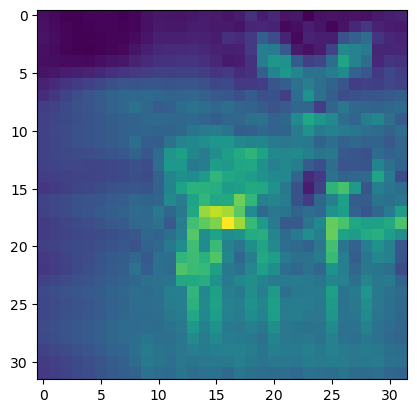

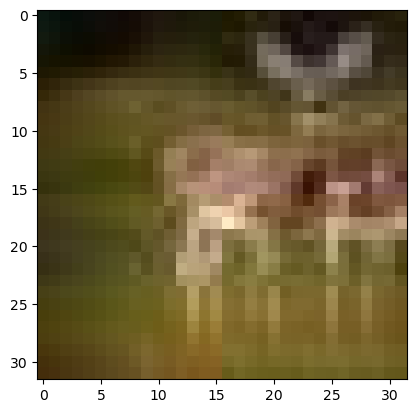

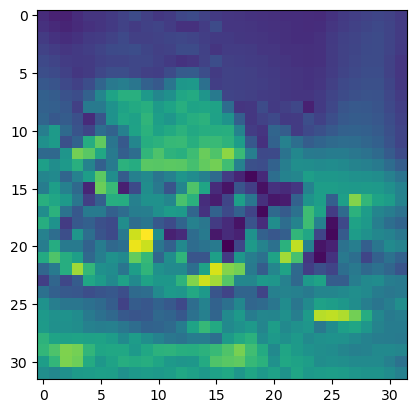

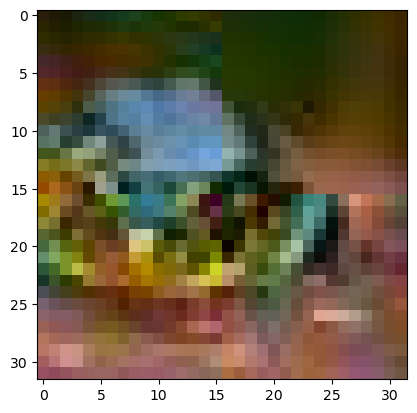

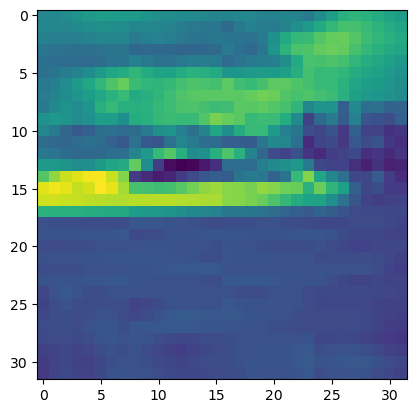

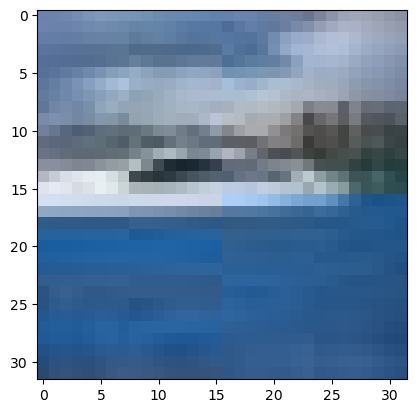

In [1]:
import torch
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

%pip install nbformat
%pip install import_ipynb

import import_ipynb
import DataCleaning

In [2]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-5

# Other constants
input_size = 32*32
num_classes = 2

train_ds_gray = DataCleaning.TRAIN_GENERATOR_GRAY
test_ds_gray = DataCleaning.TEST_GENERATOR_GRAY

# Dataloaders
train_loader = DataLoader(train_ds_gray, batch_size, shuffle=True)
test_loader = DataLoader(test_ds_gray, batch_size*2)

Model Construction

In [3]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 1024)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels.flatten().long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        # print(out.shape)
        # print(labels.shape)
        loss = F.cross_entropy(out, labels.flatten().long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = RegressionModel()

Model Training

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    labels = labels.flatten()
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

history = fit(50, 1e-4, model, train_loader, test_loader)

Epoch [0], val_loss: 0.6875, val_acc: 0.5396
Epoch [1], val_loss: 0.6866, val_acc: 0.5490
Epoch [2], val_loss: 0.6857, val_acc: 0.5533
Epoch [3], val_loss: 0.6846, val_acc: 0.5567
Epoch [4], val_loss: 0.6838, val_acc: 0.5638
Epoch [5], val_loss: 0.6829, val_acc: 0.5681
Epoch [6], val_loss: 0.6821, val_acc: 0.5710
Epoch [7], val_loss: 0.6813, val_acc: 0.5744
Epoch [8], val_loss: 0.6805, val_acc: 0.5771
Epoch [9], val_loss: 0.6797, val_acc: 0.5795
Epoch [10], val_loss: 0.6788, val_acc: 0.5803
Epoch [11], val_loss: 0.6781, val_acc: 0.5824
Epoch [12], val_loss: 0.6777, val_acc: 0.5860
Epoch [13], val_loss: 0.6770, val_acc: 0.5864
Epoch [14], val_loss: 0.6765, val_acc: 0.5875
Epoch [15], val_loss: 0.6757, val_acc: 0.5876
Epoch [16], val_loss: 0.6753, val_acc: 0.5890
Epoch [17], val_loss: 0.6747, val_acc: 0.5907
Epoch [18], val_loss: 0.6743, val_acc: 0.5912
Epoch [19], val_loss: 0.6739, val_acc: 0.5927
Epoch [20], val_loss: 0.6732, val_acc: 0.5924
Epoch [21], val_loss: 0.6727, val_acc: 0.594

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

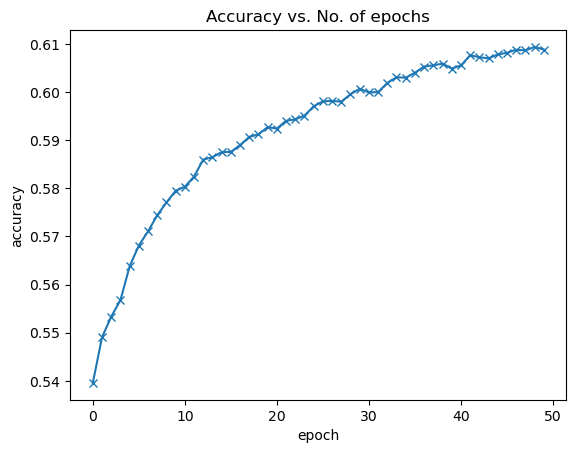

In [5]:
# Visualizing how our model performed after each epoch
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')